# Pneumonia Image Classification

This project uses Chest X-Ray images labeled with different types of Pneumonia to train a deep learning model using the [InceptionV3](https://cloud.google.com/tpu/docs/inception-v3-advanced) [Convolutional Neural Network (CNN)](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) as a starting point for [transfer learning](https://www.youtube.com/watch?v=yofjFQddwHE) to train our final model which will ultimately be able to classify X-Ray images into Pneumonia predictions.

The dataset for this project comes from the [Kaggle Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). Please download the zip file and drop the zip file into the /Data directory in this repository to get started.

## Setup

In [ ]:
# This command is for MacOSX terminal
!unzip Data/chest-xray-pneumonia.zip -d temp/
# Unzip the 2nd zip file inside the first and delete __MACOSX folder inside zip file
!zip -d temp/chest_xray.zip "__MACOSX*"
!unzip temp/chest_xray.zip -d temp/
# Change file permissions to ensure files are readable
!chmod 777 temp/*.*

In [ ]:
# Make sure we have all the required modules imported into our environment

import sys
!{sys.executable} -m pip install -U pandas
!{sys.executable} -m pip install -U matplotlib
!{sys.executable} -m pip install -U image
!{sys.executable} -m pip install -U keras
!{sys.executable} -m pip install -U tensorflow
!{sys.executable} -m pip install -U mlxtend

## Loading The Datasets

The images are organised under the temp/chest_xray folder in `train`, `test` & `val` folders. Under each of those folders are two more folders: `NORMAL` and `PNEUMONIA`. Bacterial pneumonia and Viral pneumonia can be differentiated by the filename (`bacteria` or `virus` in the filename respectively)

To allow us to train the model to predict between different types of pneumonia, we will load the list of images with their categories into dataframes.

One issue we can see is that the validation dataset has no examples of Viral pneumonia for training. This will cause our validation step during training to fail as our dataset class size is smaller so we will fix this by copying some of the virus x-rays to the validation folder.

In [3]:
# Setup the directory paths
input_directory = r"temp/chest_xray/"
training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"

import pandas as pd
import os

def load_img_dataframe(path):
    """
    Loads all image paths with their category under root directory into a Pandas dataframe
    """
    
    dataframe = pd.DataFrame(columns=['img', 'label'])
    
    # Load NORMAL images first
    normal_imgs = os.listdir(path + '/NORMAL')
    for image in normal_imgs:
        if '.jpeg' in image:
            dataframe = dataframe.append({'img' : os.path.abspath(path + '/NORMAL/' + image), 'label' : 'NORMAL'}, 
                                         ignore_index=True)
    
    # Load PNEUMONIA images next, labeling between Bacterial and Viral Pneumonia
    pneumonia_imgs = os.listdir(path + '/PNEUMONIA')
    for image in pneumonia_imgs:
        if '.jpeg' in image:
            if 'bacteria' in image:
                dataframe = dataframe.append({'img' : os.path.abspath(path + '/PNEUMONIA/' + image), 'label' : 'BACTERIAL'}, 
                                             ignore_index=True)
            if 'virus' in image:
                dataframe = dataframe.append({'img' : os.path.abspath(path + '/PNEUMONIA/' + image), 'label' : 'VIRAL'}, 
                                             ignore_index=True)
        
    return dataframe

In [ ]:
# Move 8 viral pneumonia x-rays to the validation directory
pneumonia_imgs = os.listdir(training_dir + '/PNEUMONIA')
i = 0
for image in pneumonia_imgs:
    if i >= 8:
        break
    else:
        if '.jpeg' in image:
            if 'virus' in image:
                os.rename(os.path.abspath(training_dir + '/PNEUMONIA/' + image), 
                          os.path.abspath(validation_dir + '/PNEUMONIA/' + image))
                i += 1 

In [4]:
# Load datasets
df_train = load_img_dataframe(training_dir)
df_val = load_img_dataframe(validation_dir)
df_test = load_img_dataframe(testing_dir)

# Show the head of the df_train dataset to validate it looks OK
print(df_train.iloc[0]['img'])
df_train.head()

/Users/dgildeh/Development/ML-Course/jupyter-notebooks/temp/chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg


,img,label
0,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL
1,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL
2,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL
3,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL
4,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL


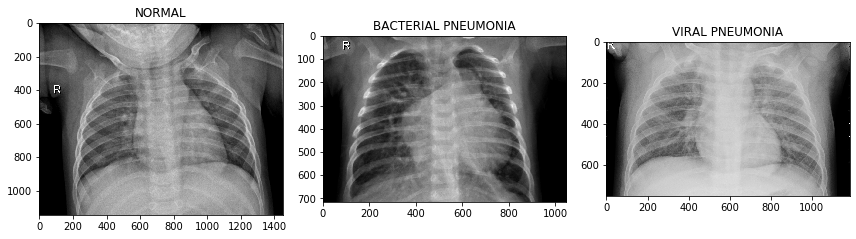

In [5]:
# Show some sample images from the training dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img_normal = plt.imread(f'{training_dir}/NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread(f'{training_dir}/PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread(f'{training_dir}/PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('BACTERIAL PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('VIRAL PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

Total Training Images: 5208
Total Validation Images: 24
Total Testing Images: 624


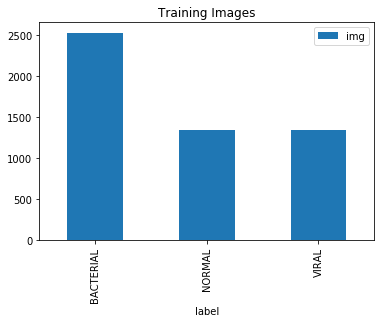

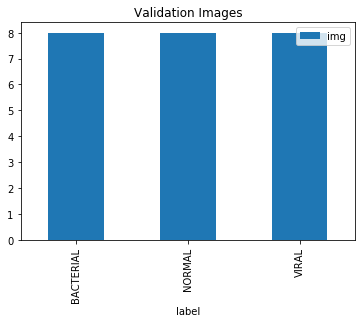

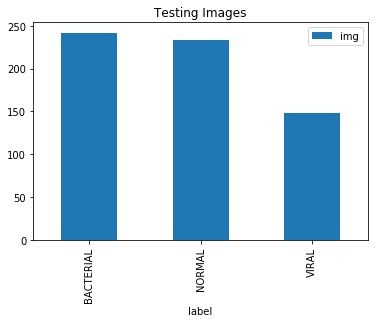

In [6]:
# Plot how many of each category we have in each dataset
def plot_img_count(df, title):
    pivot_df = pd.pivot_table(df, index='label', values='img', aggfunc='count').plot.bar(stacked=True,
                                                                                         title=title)
    print(f"Total {title}: {len(df)}")

plot_img_count(df_train, 'Training Images')
plot_img_count(df_val, 'Validation Images')
plot_img_count(df_test, 'Testing Images')

## Setup & Train Model

1. Setup the image pipeline so we can pass batches of images to the model for training
2. Load the InceptionV3 model without the top layer. This way we get transfer learning from all the other neural network layers which have been trained to recognise images on 1mil's of images (such as shapes, lines and other common image features) and replace the top categorisation layer with our own to predict the 3 labels we are training for: NORMAL, VIRAL & BACTERIAL
3. Train the model against the df_train dataset
4. Test the model using the df_test dataset

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup Image Processig Pipelines for each dataset
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='img',
    y_col='label',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_dataframe(
    df_val,
    x_col='img',
    y_col='label',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=len(df_val),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='img',
    y_col='label',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=len(df_test),
    shuffle = False)

Found 5208 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

K.clear_session()

# Load the InceptionV3 model and replace the top layer with our own layers for training
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Make sure we don't change the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# We have 3 classes we want to predict: NORMAL, BACTERIAL, VIRAL
NUM_CLASSES = 3

# Add our own 3 category classifer to the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate training class weights
y = train_generator.classes
labels = np.unique(y)
train_class_weights = compute_class_weight('balanced', labels, y)

# Train and save the model to the local 'models' directory
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              class_weight=train_class_weights,
                              workers=20)

MODEL_FILE = 'models/pneumonia_v0.1.hd5'
model.save(MODEL_FILE)

Epoch 1/100
32/32 [==============================] - 109s 3s/step - loss: 1.2465 - acc: 0.4044 - val_loss: 2.2065 - val_acc: 0.3750
Epoch 2/100
32/32 [==============================] - 97s 3s/step - loss: 1.1752 - acc: 0.4238 - val_loss: 1.9639 - val_acc: 0.2917
Epoch 3/100
32/32 [==============================] - 100s 3s/step - loss: 1.1018 - acc: 0.4679 - val_loss: 1.9187 - val_acc: 0.3333
Epoch 4/100
32/32 [==============================] - 99s 3s/step - loss: 1.0700 - acc: 0.4887 - val_loss: 1.8769 - val_acc: 0.3750
Epoch 5/100
32/32 [==============================] - 100s 3s/step - loss: 1.0436 - acc: 0.5023 - val_loss: 1.7957 - val_acc: 0.4167
Epoch 6/100
32/32 [==============================] - 100s 3s/step - loss: 1.0117 - acc: 0.5230 - val_loss: 1.9693 - val_acc: 0.4583
Epoch 7/100
32/32 [==============================] - 100s 3s/step - loss: 0.9647 - acc: 0.5524 - val_loss: 1.8817 - val_acc: 0.3750
Epoch 8/100
32/32 [==============================] - 101s 3s/step - loss: 0.96

32/32 [==============================] - 102s 3s/step - loss: 0.7158 - acc: 0.6909 - val_loss: 1.2744 - val_acc: 0.5000
Epoch 63/100
32/32 [==============================] - 103s 3s/step - loss: 0.6988 - acc: 0.6912 - val_loss: 1.3033 - val_acc: 0.5000
Epoch 64/100
32/32 [==============================] - 99s 3s/step - loss: 0.7089 - acc: 0.6939 - val_loss: 1.2848 - val_acc: 0.4583
Epoch 65/100
32/32 [==============================] - 100s 3s/step - loss: 0.6966 - acc: 0.6941 - val_loss: 1.3047 - val_acc: 0.5000
Epoch 66/100
32/32 [==============================] - 101s 3s/step - loss: 0.6956 - acc: 0.6970 - val_loss: 1.3252 - val_acc: 0.5000
Epoch 67/100
32/32 [==============================] - 100s 3s/step - loss: 0.6860 - acc: 0.6947 - val_loss: 1.2676 - val_acc: 0.5417
Epoch 68/100
32/32 [==============================] - 102s 3s/step - loss: 0.6949 - acc: 0.6924 - val_loss: 1.2666 - val_acc: 0.5417
Epoch 69/100
32/32 [==============================] - 99s 3s/step - loss: 0.7087 - 

## Model Performance Over The Epochs

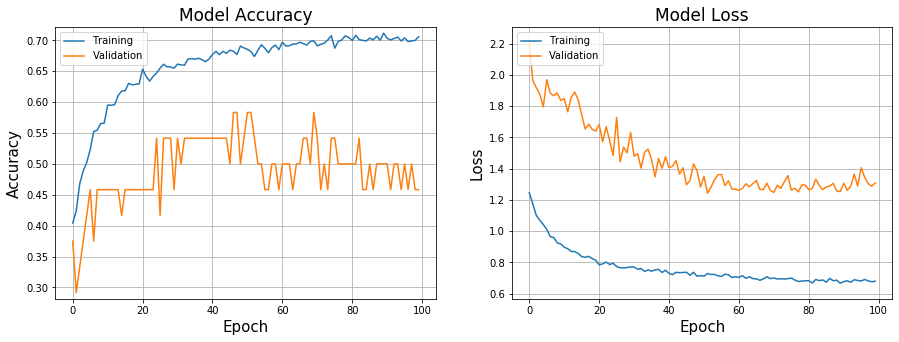

In [13]:
# Setup graph
xlabel = 'Epoch'
legends = ['Training', 'Validation']
ylim_pad = [0.01, 0.1]
plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values
y1 = history.history['acc']
y2 = history.history['val_acc']
min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]
plt.subplot(121)
plt.plot(y1)
plt.plot(y2)
plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
             
# Plot training & validation loss values
y1 = history.history['loss']
y2 = history.history['val_loss']
min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
plt.subplot(122)
plt.plot(y1)
plt.plot(y2)
plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

## Test Saved Model

We will reload the saved model and test it against the test data to score its accuracy with new data.

In [19]:
import tensorflow as tf

# Load the model from the saved model file
test_model = tf.keras.models.load_model(MODEL_FILE)
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
# Evaluate the model using the test data
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print(f"Loss     : {round(result[0], 2)}")
print(f"Accuracy : {round(result[1]*100, 2)}%")

1/1 [==============================] - 14s 14s/step - loss: 1.2479 - acc: 0.5321
Loss     : 1.25
Accuracy : 53.21%


In [29]:
# Load predictions and classes into arrays from model and generator
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes
classes = df_test.label.unique()

1/1 [==============================] - 14s 14s/step


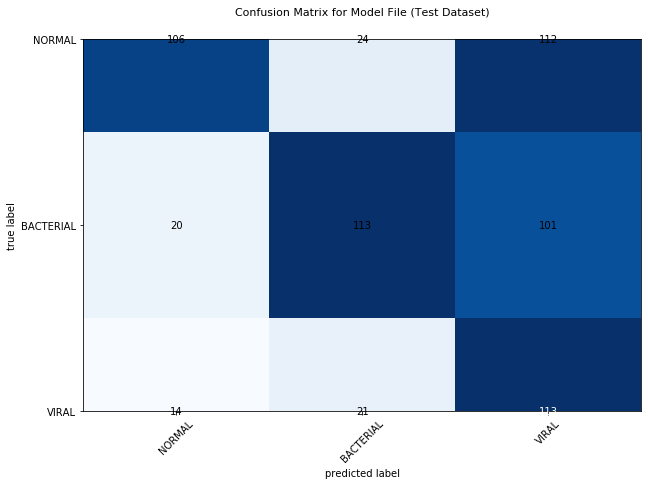

In [50]:
# Plot a confusion matrix of the predictions vs. the true class
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

CM = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat = CM, 
                                figsize = (10,10), 
                                class_names = classes,
                                cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Model File (Test Dataset)", fontsize=11)
plt.show()

In [75]:
# Make utility function for selecting a number of random samples in the test data and plotting their prediction vs.
# what the sample actually is

def show_predictions(y_pred, y_true, class_names, test_generator, ncols=4, nrows=2, offset=0):
    """
    Pass in the model with the number of images you want to test (count) and will
    display the test images with their actual class and predicted class
    
    @param y_pred          An array of predicted classifications for the images from the test_generator
    @param y_true          An array of the true classifications for the images from the test_generator
    @param class_names     An array of the class names to convert the prediction/true arrays into text class names
    @param test_generator  The test generator with all the test samples to test
    @param ncols           Number of images to display per row (default=4)
    @param nrows           Number of rows of images to display (default=2)
    @param offset          If given, will start showing image predictions from the offset number given (default=0)
    """
    count = ncols * nrows
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2.5, nrows*2.5),
        dpi=100, facecolor='w', edgecolor='k', subplot_kw={'xticks': [], 'yticks': []})
    plt.rcParams.update({'axes.titlesize': 'small'})
    plt.subplots_adjust(0.5, 0.3)
    
    pneumonia_classes = ['BACTERIAL', 'VIRAL']
        
    for i in range(0, count):
        plt.subplot(nrows, ncols, i+1)
        img = plt.imread(test_generator.filenames[offset + i])
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        original = class_names[y_true[offset + i]]
        predicted = class_names[y_pred[offset + i]]
        
        title_text = f"True: {original}\nPred: {predicted}"
        
        if original==predicted:
            plt.title(title_text, color='green')
        elif (original in pneumonia_classes) and (predicted in pneumonia_classes):
            plt.title(title_text, color='orange')
        else:
            plt.title(title_text, color='red')
    
    plt.show()   

### Visualisation 1

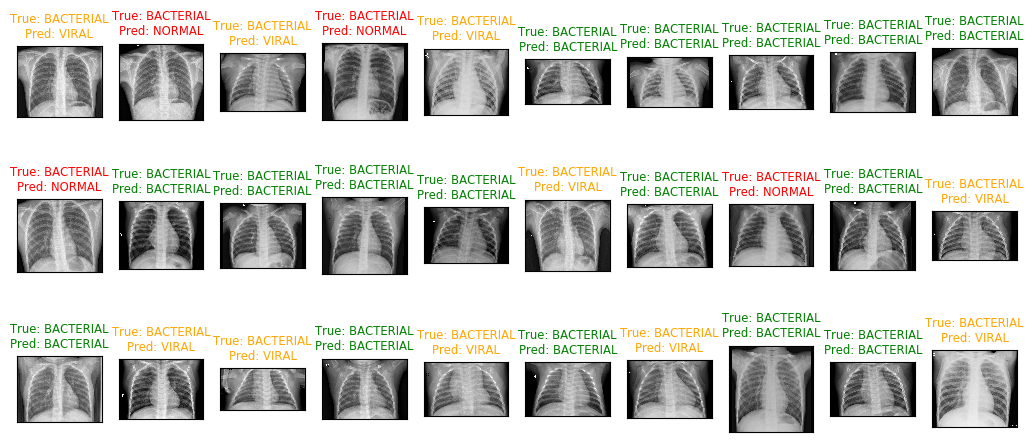

In [76]:
show_predictions(y_pred, y_true, classes, test_generator, 10, 3) 

### Visualisation 2

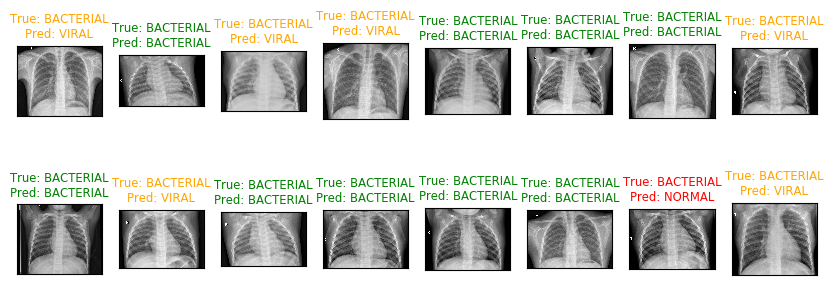

In [77]:
show_predictions(y_pred, y_true, classes, test_generator, 8, 2, 30) 

## Conclusion

In this exercise we have seen how to use transfer learning with the InceptionV3 model and train it on a medical xray dataset to automatically classify pneumonia.

The model only has a 53% accuracy rate after training, leading to a lot of incorrect predictions as you can see in the 2 examples above. However, if you look at the test visualisations above, most of the incorrect predictions do predict pneumonia but the incorrect type of pneumonia. This could be improved with more training examples for the different types of pneumonia and also adding more layers to our model as we only did 3 simple layers for this excercise which may limit the ability of the model to see more subtle differences between the types of pneumonia.